# Quantum Autoencoder

We show an example of a quantum model on the MNIST dataset

## imports

In [ ]:
# A Python library for quantum machine learning
!pip install -q pennylane==0.36.0

In [154]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pennylane.optimize import AdamOptimizer
from sklearn.metrics import roc_auc_score, roc_curve
import time
from sklearn import decomposition

## Data

We load the dataset

In [127]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

As an example we use images with threes as background and want to tag sixes as anomalies, so we seperate the two.

In [128]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x, y


x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [129]:
x_train_threes = np.array(x_train[y_train == True])
x_train = np.array(x_train[y_train == False])

x_test_threes = np.array(x_test[y_test == True])
x_test = np.array(x_test[y_test == False])

In [130]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_train_threes = x_train_threes.reshape(x_train_threes.shape + (1,))
x_test_threes = x_test_threes.reshape(x_test_threes.shape + (1,))

To reduce the computational resources needed for training, we reduce the dataset using a PCA.
Here we choose nine components.

In [157]:
pca = decomposition.PCA(9)

In [158]:
x_threes_pca = pca.fit_transform(x_train_threes.reshape(-1, 28 * 28))

In [159]:
x_pca = pca.transform(x_train.reshape(-1, 28 * 28))

## Model

Now we build our model. The quantum autoencoder encodes the 9 features of the data in 9 data qubits and compresses it down to 5 qubits in the latent space.

In [160]:
LATENT_QBITS = 5
DRCs = 2
EPOCHS = 3

DATA_QBITS = 9
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

To perform a quantum simulation you have to define a device in pennylane.

In [146]:
dev1 = qml.device("lightning.qubit", wires=TOTAL_QBITS)

Here we define our model. It consists of a circuit and variational parameters which we will optimize during training.

In [147]:
class baseSQAE:
    """base class for an SQAE architecture with a simple encoding"""

    def __init__(self, data_qbits, latent_qbits, device, layers=1, diff_method="best"):
        """Create basic SQAE

        Args:
            data_qbits (int): number of qbits to upload data and use as encoder
            latent_qbits (int): number of latent qbits
            device (pennylane device): pennylane device to use for circuit evaluation
            diff_method (str): method to differentiate quantum circuit, usually "adjoint" ist best.
        """

        self.dev = device
        self.data_qbits = data_qbits
        self.latent_qbits = latent_qbits
        self.trash_qbits = self.data_qbits - self.latent_qbits
        self.total_qbits = data_qbits + self.trash_qbits + 1
        self.circuit_node = qml.QNode(self.circuit, device, diff_method=diff_method)

        self.auc_hist = []

        self.parameters_shape = (layers * 2 * data_qbits,)
        self.data_shape = (data_qbits,)
        self.layers = layers
        self.params = np.random.uniform(size=self.parameters_shape, requires_grad=True)

        self.rnd_init = np.random.uniform(
            0, np.pi, size=self.trash_qbits, requires_grad=False
        )

    def encoder(self, params, data):
        """Builds encoder circuit

        Args:
            params (list): parameters to be used for PQC
            data (list): data for the circuit

        """
        for i in range(self.layers):
            for j in range(self.data_qbits):
                qml.RY(
                    params[i * 2 * self.data_qbits : (i + 1) * 2 * self.data_qbits][
                        j * 2
                    ]
                    + params[i * 2 * self.data_qbits : (i + 1) * 2 * self.data_qbits][
                        j * 2 + 1
                    ]
                    * data[j],
                    wires=j,
                )
            qml.CNOT(wires=[self.data_qbits - 1, 0])
            for k in range(self.data_qbits - 1):
                qml.CNOT(wires=[k, k + 1])

    def circuit(self, params, data):
        """Full circuit to be used as SQAE

        includes encoder and SWAP test

        Args:
            params (list): parameters to be used for PQC
            data (list): data for the circuit

        Returns:
            expectation value of readout bit

        """

        self.encoder(params, data)

        # swap test
        qml.Hadamard(wires=self.total_qbits - 1)
        for i in range(self.trash_qbits):
            qml.CSWAP(
                wires=[self.total_qbits - 1, self.latent_qbits + i, self.data_qbits + i]
            )
        qml.Hadamard(wires=self.total_qbits - 1)

        return qml.expval(qml.PauliZ(self.total_qbits - 1))

    def plot_circuit(self):
        """Plots the circuit with dummy data"""

        data = np.random.uniform(size=self.data_shape)

        fig, _ = qml.draw_mpl(self.circuit_node)(self.params, data)
        fig.show()

    def train(
        self,
        x_train,
        x_val,
        learning_rate,
        epochs,
        batch_size,
        print_step_size=20,
        make_animation=False,
        save_auc=False,
        x_val_signal=None,
    ):
        """Trains the SQAE

        Args:
            x_train (list): training data
            y_val (list): validation data
            learning_rate (float): learning rate for adam
            epoch (int): epochs to train
            batch_size (int): batch size to use for training
            print_step_size (int): after print_step_size loss on current batch is printed
                                   if make_animation or save_auc is True, they will be evaluated
                                   after print_step_size as well.
            make_animation (bool): if True build gif of certain bit and tagging evaluation after every
                                   print_step_size steps.
            save_auc (bool): If true, AUC will be recorded after every print_step_size steps.
                             If True x_val_signal needs to be given.
            x_val_signal (list): if save_auc is True use this data to evaluate AUC on anomaly tagging.

        """

        self.train_hist = {"loss": [], "val_loss": []}

        opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

        start = time.time()

        for it in range(epochs):
            start_b = time.time()
            for j, Xbatch in enumerate(
                self.iterate_minibatches(x_train, batch_size=batch_size)
            ):
                cost_fn = lambda p: self.cost_batch(p, Xbatch)
                self.params = opt.step(cost_fn, self.params)
                print(j, end="\r")
                if j % print_step_size == 0 and not j == 0:
                    end_b = time.time()
                    loss = self.cost_batch(self.params, Xbatch)
                    if not save_auc:
                        print(
                            f"Step: {j:<7} | Loss: {loss:<10.3} | avg step time {(end_b - start_b) / print_step_size :.3} | avg gradient {np.mean(self.params):.3}"
                        )
                    if save_auc:
                        pred_bg = np.array(
                            [self.circuit_node(self.params, i) for i in x_val]
                        )
                        pred_signal = np.array(
                            [self.circuit_node(self.params, i) for i in x_val_signal]
                        )
                        bce_background = 1 - pred_bg
                        bce_signal = 1 - pred_signal
                        y_true = np.append(
                            np.zeros(len(bce_background)), np.ones(len(bce_signal))
                        )
                        y_pred = np.append(bce_background, bce_signal)
                        auc = roc_auc_score(y_true, y_pred)
                        self.auc_hist.append(auc)
                        print(
                            f"Step: {j:<7} | Loss: {loss:<10.3} | avg step time {(end_b - start_b) / print_step_size :.3} | auc: {auc:.3} | avg gradient {np.mean(self.params):.3}"
                        )
                    start_b = time.time()

            loss = self.cost_batch(self.params, x_train[: len(x_val)])
            val_loss = self.cost_batch(self.params, x_val)
            self.train_hist["loss"].append(loss)
            self.train_hist["val_loss"].append(val_loss)
            print("____")
            print(f"Epoch: {it:<5} | Loss: {loss:<10.3} | Val Loss {val_loss:.3}")
            print("____")

        end = time.time()

        print(f"Time for {epochs} epochs: {end - start}")

    def iterate_minibatches(self, data, batch_size):
        """Generator of data as batches

        Args:
            data (list): list of data
            batch_size (int): size of batches to return
        """
        for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
            idxs = slice(start_idx, start_idx + batch_size)
            yield data[idxs]

    def cost_batch(self, params, batch):
        """evaluate cost function on batch - MSE of fidelities

        Args:
            params: parameters to use for evaluation
            batch: batch of data

        Returns:
            Average loss (1 - fidelity) of batch
        """
        loss = 0.0
        for i in batch:
            sample_loss = self.circuit_node(params, i)
            loss = loss + (1 - sample_loss) ** 2
        return loss / len(batch)

    def evaluate(self, x_test_bg, x_test_signal, save_fig=None):
        """Evaluate tagging performance on test data giving auc and roc curve

        Args:
            x_test_bg (list): background data (same class the model was trained on)
            x_test_signal (list): signal data (model has never seen data from this class)
            save_fig (str): if a string is given the resulting plots will be save to the given path
        """

        pred_bg = np.array([self.circuit_node(self.params, i) for i in x_test_bg])
        if not save_fig:
            print("Median fidelities bg: ", np.median(pred_bg))

        pred_signal = np.array(
            [self.circuit_node(self.params, i) for i in x_test_signal]
        )
        if not save_fig:
            print("Median fidelities signal: ", np.median(pred_signal))

        bce_background = 1 - pred_bg
        bce_signal = 1 - pred_signal

        fig, axs = plt.subplots(1, 3, figsize=(11, 4))

        if not save_fig:
            print(f"Median background: {np.median(bce_background):.3}")
        if not save_fig:
            print(f"Median signal: {np.median(bce_signal):.3}")
        bins = np.histogram(np.hstack((bce_background, bce_signal)), bins=25)[1]
        axs[0].hist(bce_background, histtype="step", label="background", bins=bins)
        axs[0].hist(bce_signal, histtype="step", label="signal", bins=bins)
        # axs[0].set_xlim(0,0.5)
        axs[0].set_xlabel("loss")
        axs[0].legend()

        thresholds = np.linspace(
            0, max(np.max(bce_background), np.max(bce_signal)), 1000
        )

        accs = []
        for i in thresholds:
            num_background_right = np.sum(bce_background < i)
            num_signal_right = np.sum(bce_signal > i)
            acc = (num_background_right + num_signal_right) / (
                len(pred_bg) + len(pred_signal)
            )
            accs.append(acc)

        if not save_fig:
            print(f"Maximum accuracy: {np.max(accs):.3}")
        axs[1].plot(thresholds, accs)
        axs[1].set_xlabel("anomaly threshold")
        axs[1].set_ylabel("tagging accuracy")
        # axs[1].set_xlim(0,0.5)

        y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
        y_pred = np.append(bce_background, bce_signal)
        auc = roc_auc_score(y_true, y_pred)
        if not save_fig:
            print(f"AUC: {auc:.4}")
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        tnr = 1 - fpr
        x = np.linspace(0, 1, 200)
        y_rnd = 1 - x
        axs[2].plot(tnr, tpr, label=f"anomaly tagger, auc:{auc:.3}")
        axs[2].plot(x, y_rnd, label="random tagger", color="grey")
        axs[2].set_xlabel("fpr")
        axs[2].set_ylabel("tpr")
        axs[2].legend(loc="lower left")

        fig.tight_layout()
        if save_fig:
            plt.savefig(save_fig)
            plt.close()

    def plot_train_hist(self, logscale=False):
        """Plot the history of the training and vaidation loss

        Args:
            logscale (bool): if true y scale will be plottet logarithmic
        """
        plt.plot(self.train_hist["loss"], label="train")
        plt.plot(self.train_hist["val_loss"], label="val")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        if logscale:
            plt.yscale("log")
        plt.show()

In [151]:
model = baseSQAE(DATA_QBITS, LATENT_QBITS, dev1, layers=2, diff_method="best")

We can plot the circuit of the model. It consists of a circuit which uploads the data and contains the variational parameters, followed by a swap test in order to reduce to the latent space.

/tmp/ipykernel_525479/3965646239.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


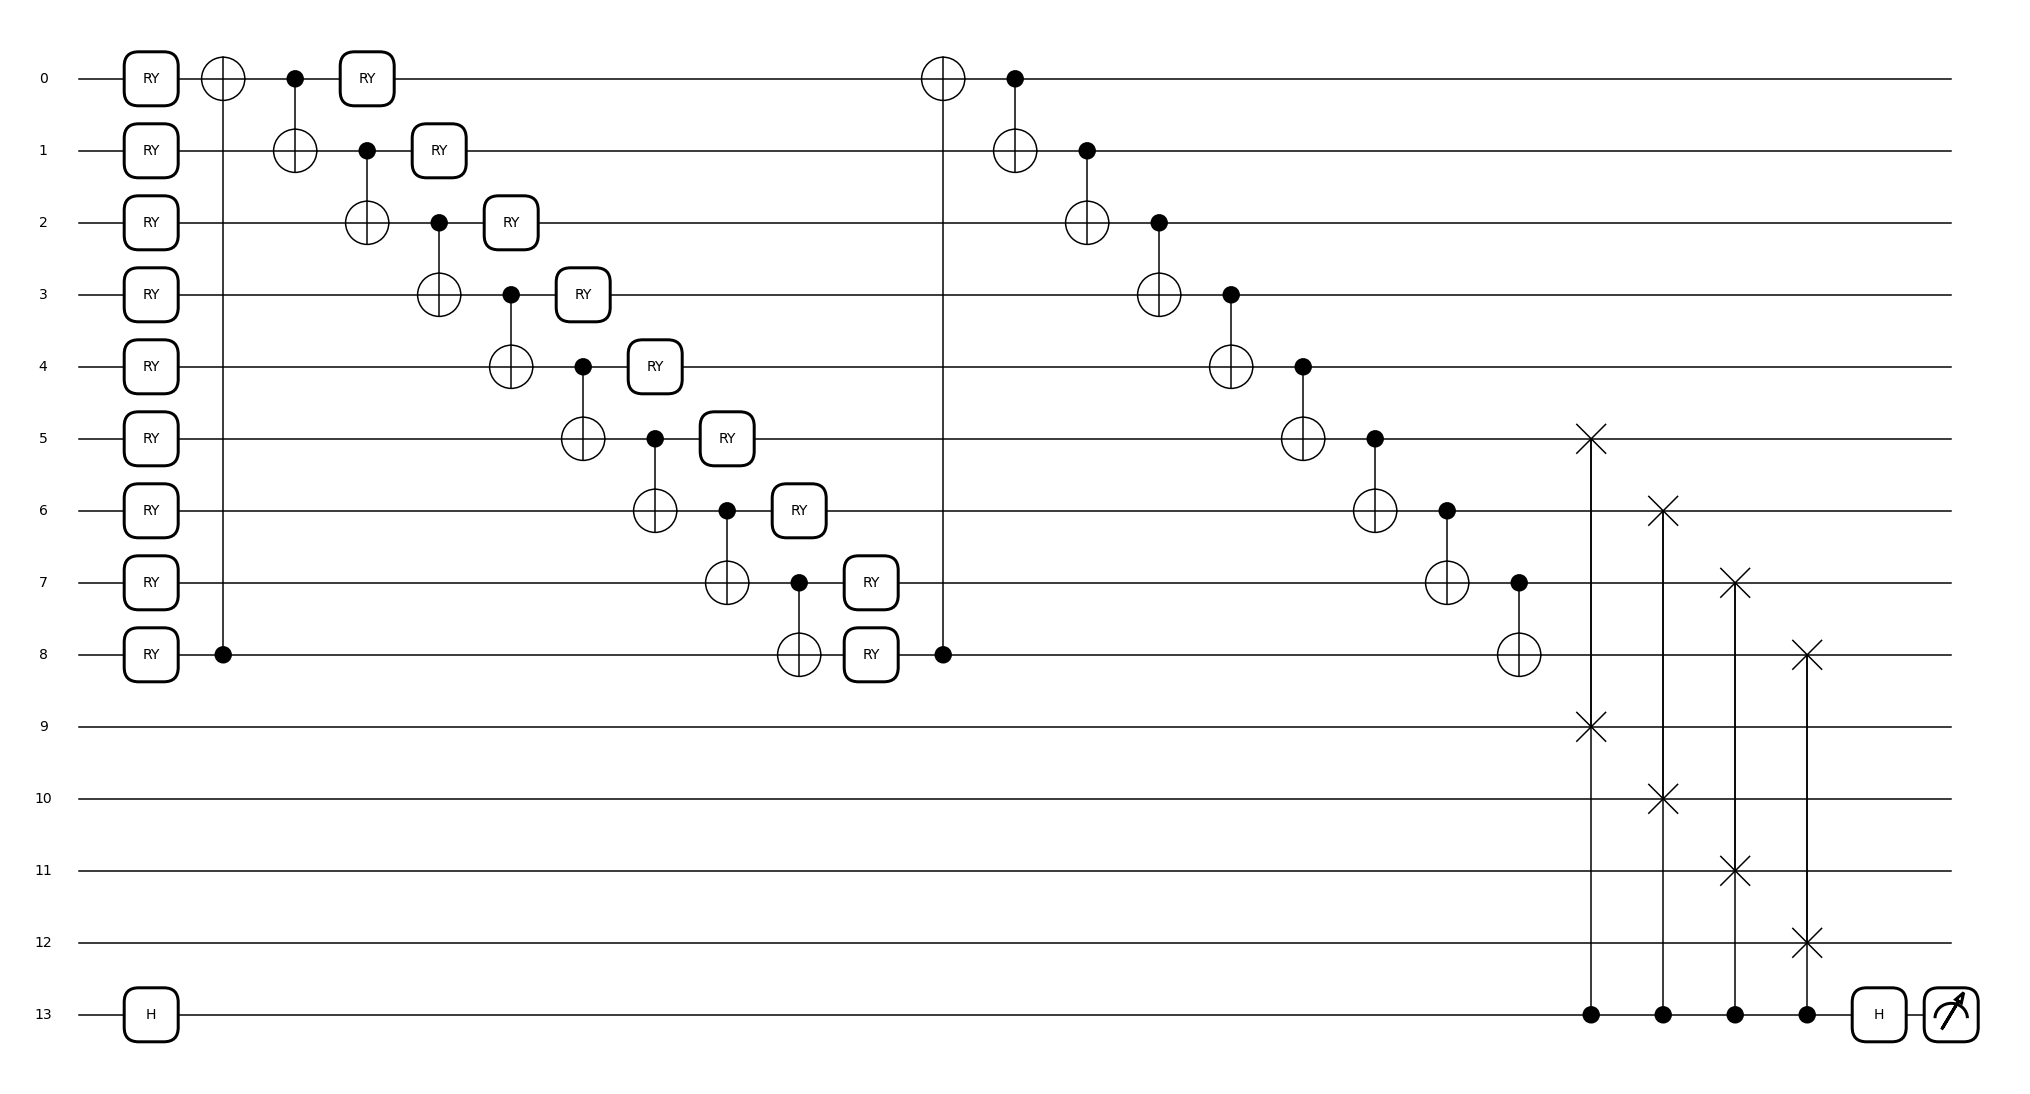

In [162]:
model.plot_circuit()

In [152]:
model.train(
    x_threes_pca,
    x_threes_pca,
    learning_rate=0.001,
    epochs=EPOCHS,
    batch_size=30,
    print_step_size=50,
    save_auc=True,
    x_val_signal=x_pca,
)

Step: 50      | Loss: 0.751      | avg step time 58.9 | auc: 0.471 | avg gradient 0.545
Step: 100     | Loss: 0.751      | avg step time 1.95 | auc: 0.488 | avg gradient 0.529
Step: 150     | Loss: 0.731      | avg step time 2.03 | auc: 0.505 | avg gradient 0.511
Step: 200     | Loss: 0.689      | avg step time 2.07 | auc: 0.524 | avg gradient 0.493
____
Epoch: 0     | Loss: 0.682      | Val Loss 0.682
____
Step: 50      | Loss: 0.652      | avg step time 2.04 | auc: 0.553 | avg gradient 0.469
Step: 100     | Loss: 0.667      | avg step time 2.06 | auc: 0.589 | avg gradient 0.442
Step: 150     | Loss: 0.598      | avg step time 2.14 | auc: 0.621 | avg gradient 0.414
Step: 200     | Loss: 0.574      | avg step time 2.08 | auc: 0.666 | avg gradient 0.385
____
Epoch: 1     | Loss: 0.554      | Val Loss 0.554
____
Step: 50      | Loss: 0.479      | avg step time 2.13 | auc: 0.735 | avg gradient 0.349
Step: 100     | Loss: 0.505      | avg step time 2.02 | auc: 0.797 | avg gradient 0.317
St

We can evaluate the model similar to the example of the classical autoencoder

Median fidelities bg:  0.3997924797014055
Median fidelities signal:  0.2156281206435659
Median background: 0.6
Median signal: 0.784
Maximum accuracy: 0.824
AUC: 0.8874


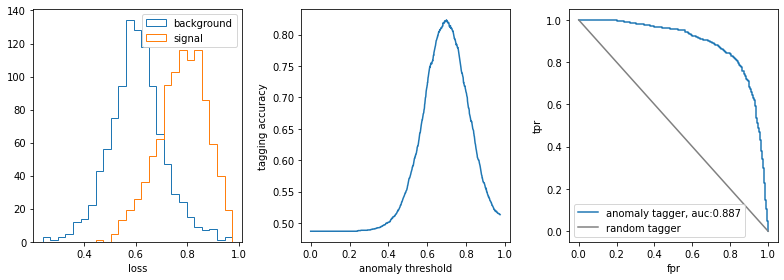

In [153]:
model.evaluate(
    pca.transform(x_test_threes.reshape(-1, 28 * 28)),
    pca.transform(x_test.reshape(-1, 28 * 28)),
)

For MNIST we achieve a good accuracy. 